In [1]:
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"

from docker import classify
from docker import util
import numpy as np
import pandas as pd

from prospect.io import read_results as reader
from prospect.plotting import corner
from prospect.plotting.utils import best_sample

import matplotlib.pyplot as plt

file1 = "dr10_lensed_param_csp.h5"
file2 = "dr10_unlensed_param_csp.h5"
file3 = '/global/homes/e/eramey16/galactic_lenses/160411A_1695693223_mcmc.h5'
file4 = '160411A_1695850628_mcmc.h5' # lensed w/free redshift
file5 = ''

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
iptf16 = {
    'ls_id': 9906619143751091,
    'ra': 316.066215680906,
    'dec': -6.34022115158153
}
unlensed = {
    'ls_id': 10995426317568050,
    'ra': 316.060774,
    'dec': -6.302004
}

In [29]:
trac = classify.query_galaxy(iptf16['ra'], iptf16['dec'])
trac.columns

Index(['brickid', 'brickname', 'ls_id', 'ra', 'dec', 'type', 'dered_mag_g',
       'dered_mag_r', 'dered_mag_i', 'dered_mag_z', 'dered_mag_w1',
       'dered_mag_w2', 'dered_flux_g', 'dered_flux_r', 'dered_flux_i',
       'dered_flux_z', 'dered_flux_w1', 'dered_flux_w2', 'snr_g', 'snr_r',
       'snr_i', 'snr_z', 'snr_w1', 'snr_w2', 'flux_ivar_g', 'flux_ivar_r',
       'flux_ivar_i', 'flux_ivar_z', 'flux_ivar_w1', 'flux_ivar_w2',
       'dchisq_1', 'dchisq_2', 'dchisq_3', 'dchisq_4', 'dchisq_5', 'rchisq_g',
       'rchisq_r', 'rchisq_i', 'rchisq_z', 'rchisq_w1', 'rchisq_w2', 'sersic',
       'sersic_ivar', 'psfsize_g', 'psfsize_r', 'psfsize_z', 'shape_r',
       'shape_e1', 'shape_e2', 'shape_r_ivar', 'shape_e1_ivar',
       'shape_e2_ivar', 'z_phot_median', 'z_phot_std', 'z_spec'],
      dtype='object')

In [30]:
list(trac[['dered_mag_'+b for b in bands]].iloc[0])

[20.144327, 18.742605, 18.173893, 17.796282, 17.236155, 17.585125]

In [4]:
bands = ['g', 'r', 'i', 'z', 'w1', 'w2']
filters = [f'dered_mag_{x}' for x in bands]
sig_f = np.array([(trac['flux_ivar_'+b])**-.5 for b in bands])
f = np.array([trac['dered_flux_'+b] for b in bands])
sig_m = 2.5 / np.log(10) * sig_f / f
sig_m

array([[0.00456459],
       [0.00203683],
       [0.00473537],
       [0.00142861],
       [0.00718577],
       [0.01743471]])

In [31]:
trac = classify.query_galaxy(unlensed['ra'], unlensed['dec'])
trac

,brickid,brickname,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_i,dered_mag_z,...,psfsize_z,shape_r,shape_e1,shape_e2,shape_r_ivar,shape_e1_ivar,shape_e2_ivar,z_phot_median,z_phot_std,z_spec
0,295677,3161m062,10995426317568050,316.060774,-6.302004,SER,19.971344,19.177868,18.76374,18.528467,...,1.380815,2.028592,-0.730338,0.002433,49216.9,235262.52,279869.4,0.141535,0.02283,-99.0


In [32]:
list(trac[['dered_mag_'+b for b in bands]].iloc[0])

[19.971344, 19.177868, 18.76374, 18.528467, 18.416647, 18.769682]

In [33]:
2.5 / np.log(10) / np.array([trac['snr_'+b][0] for b in bands])

array([0.00533879, 0.00345792, 0.01143685, 0.00278628, 0.01649121,
       0.04711887])

In [8]:
data = classify.query_galaxy(iptf16['ra'], iptf16['dec'], radius=.1, limit=100)
data = util.clean_and_calc(data, mode='dr9')
data['mag_diff'] = np.abs(trac.dered_mag_r[0] - data.dered_mag_r)
data.sort_values(by='mag_diff').dropna()

,brickid,brickname,ls_id,ra,dec,type,dered_mag_g,dered_mag_r,dered_mag_i,dered_mag_z,...,flux_sigma_g,flux_sigma_r,flux_sigma_i,flux_sigma_z,flux_sigma_w1,flux_sigma_w2,min_dchisq,sum_rchisq,abs_mag_r,mag_diff
77,295677,3161m062,10995426317568600,316.076199,-6.328060,EXP,20.318012,19.460712,19.242052,18.899273,...,0.033497,0.048857,0.244840,0.079080,0.613328,1.294504,156547.88000,5.498271,-20.772617,0.282844
0,295677,3161m062,10995426317568240,316.066181,-6.340227,SER,20.144327,18.742605,18.173893,17.796282,...,0.036808,0.059730,0.234462,0.100156,0.843893,1.484706,584451.56000,39.428580,-21.518800,0.435263
20,295677,3161m062,10995426317568527,316.074266,-6.338018,REX,22.690111,20.871824,20.197464,19.826258,...,0.026630,0.039591,0.190402,0.074528,0.634419,1.267646,0.00000,16.257974,-20.763028,1.693956
40,295677,3161m062,10995426317568670,316.077916,-6.341720,REX,21.917408,20.877700,20.588125,20.297676,...,0.035527,0.052456,0.254053,0.099650,0.660404,1.313779,0.00000,20.919803,-20.882869,1.699832
59,295677,3161m062,10995426317568742,316.079758,-6.336583,DEV,23.311447,21.943132,21.180918,20.815506,...,0.030109,0.043057,0.218695,0.083734,0.582518,1.260291,3649.68480,9.548733,-20.186861,2.765264
3,295677,3161m062,10995426317568328,316.068724,-6.335661,REX,23.191528,21.972113,20.901495,20.536540,...,0.025048,0.035479,0.179255,0.069144,0.589990,1.233074,0.00000,11.839161,-20.593014,2.794245
75,295677,3161m062,10995426317568788,316.081306,-6.343598,EXP,24.044111,22.219349,21.571785,21.183657,...,0.025291,0.035908,0.182553,0.069616,0.572107,1.224764,1994.92430,8.631972,-19.457654,3.041481
39,295677,3161m062,10995426317568100,316.062274,-6.351093,EXP,23.253181,22.521189,21.524296,21.550335,...,0.030783,0.047274,0.251751,0.082582,0.598679,1.286431,505.60513,11.391046,-20.618039,3.343321
12,295677,3161m062,10995426317568267,316.067109,-6.333126,REX,23.926962,22.919794,22.164064,22.212883,...,0.022493,0.031075,0.161259,0.059812,0.591287,1.260158,0.00000,10.920502,-19.319612,3.741926
96,295677,3161m062,10995426317567647,316.049350,-6.344135,REX,23.939837,23.007505,23.827291,22.838846,...,0.026506,0.038589,0.172260,0.070133,0.519495,1.210479,0.00000,4.441559,-18.882951,3.829637


In [15]:
def make_plots_for_h5(h5_file, ax_range=None, save=True, traceplot=False):
    h5_handle = h5_file.split('.')[0]
    
    res, obs, model = reader.results_from(h5_file)
    
    if traceplot:
        tracefig = reader.traceplot(res)
        if save:
            savefile = 'figs/'+h5_handle+'_tracefig.png'
            plt.savefig(savefile, bbox_inches='tight')
    
    cornerfig = reader.subcorner(res, range=ax_range)
    if save:
        savefile = 'figs/'+h5_handle+'_subcorner.png'
        plt.savefig(savefile, bbox_inches='tight')
    
#     try: # better corner plot
#         nsamples, ndim = res["chain"].shape[-2:]
#         cfig, axes = plt.subplots(ndim, ndim, figsize=(15,11))
#         axes = corner.allcorner(res["chain"].T, ['Mass', r'SFH ($\tau$)', 'Dust', 'Metallicity',
#                                                  'log($T_{max}$)'], axes, weights=res["weights"], 
#                                 color="royalblue", show_titles=True)
#         print([(ax.get_xlim(), ax.get_ylim()) for ax in axes])
#         pbest = best_sample(res)
#         corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")
#         plt.tight_layout()
#         # plt.suptitle("Prospector fit for IPTF16geu", fontsize=20)
#         cfig.patch.set_facecolor('white')
        
#         if save:
#             savefile = 'figs/'+h5_handle+'_corner.png'
#             plt.savefig(savefile, bbox_inches='tight')
#     except: pass

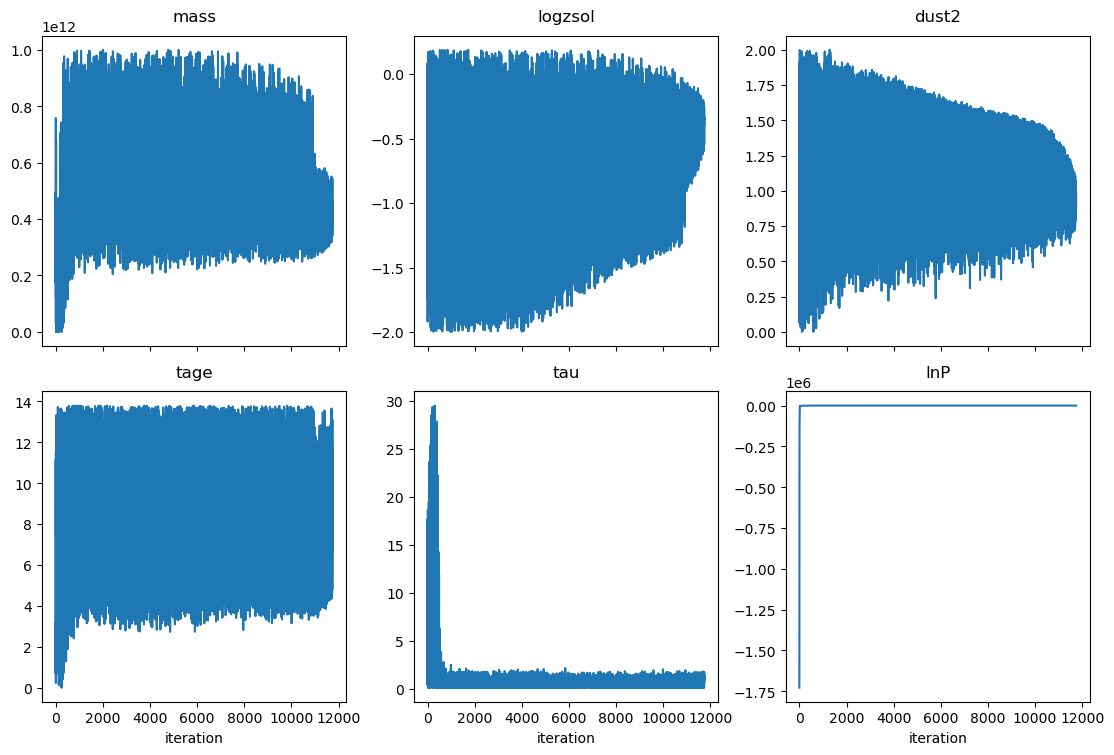

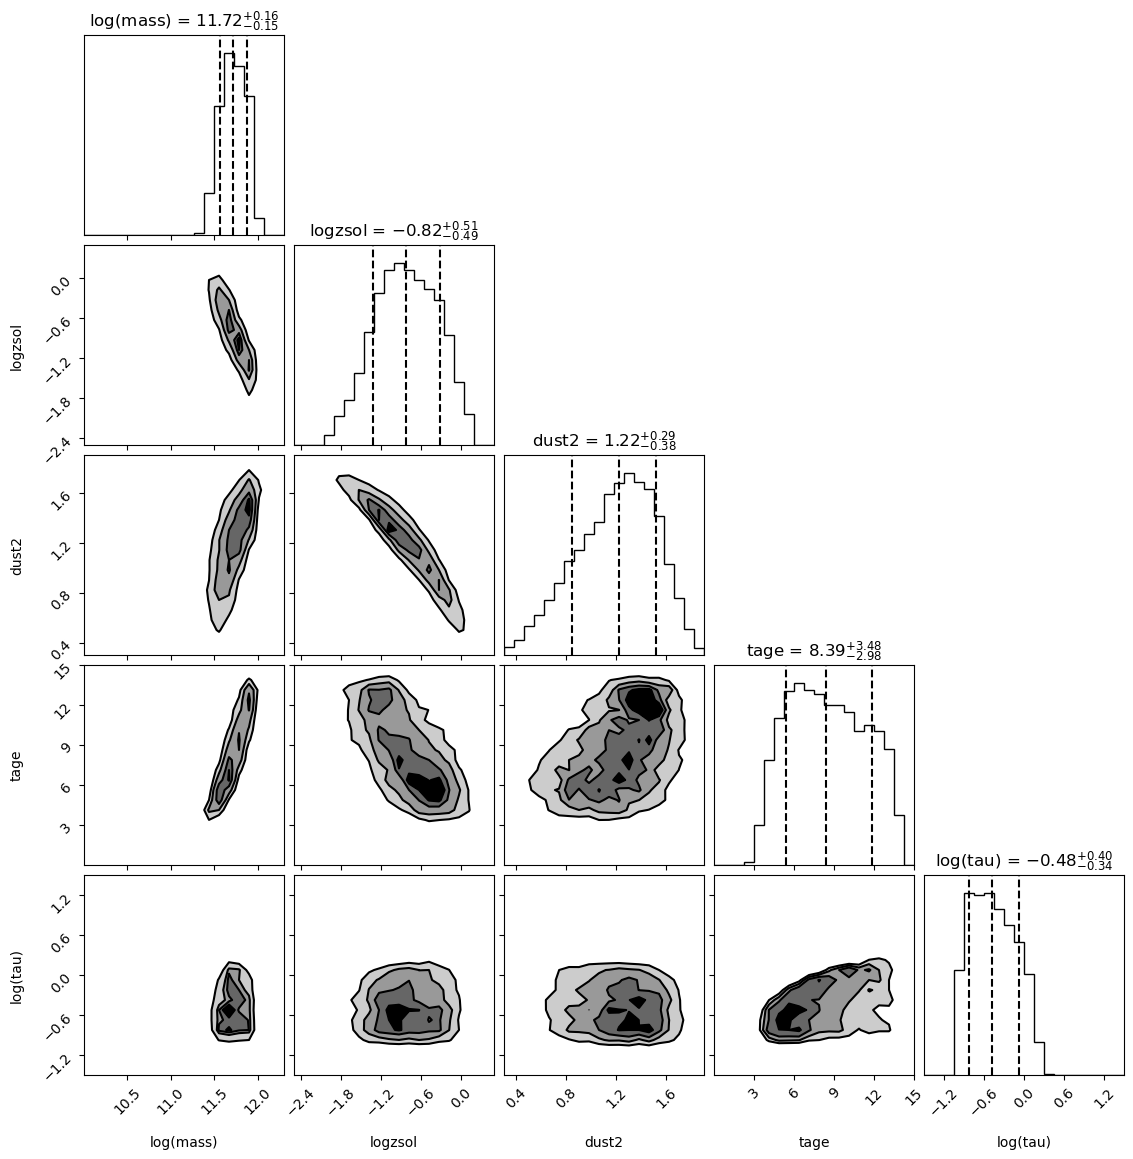

In [10]:
ax_range=[(10,12.3), (-2.5, .5), (0.3, 1.9), (0, 15), (-1.5, 1.5)]
make_plots_for_h5(file1, ax_range=ax_range)

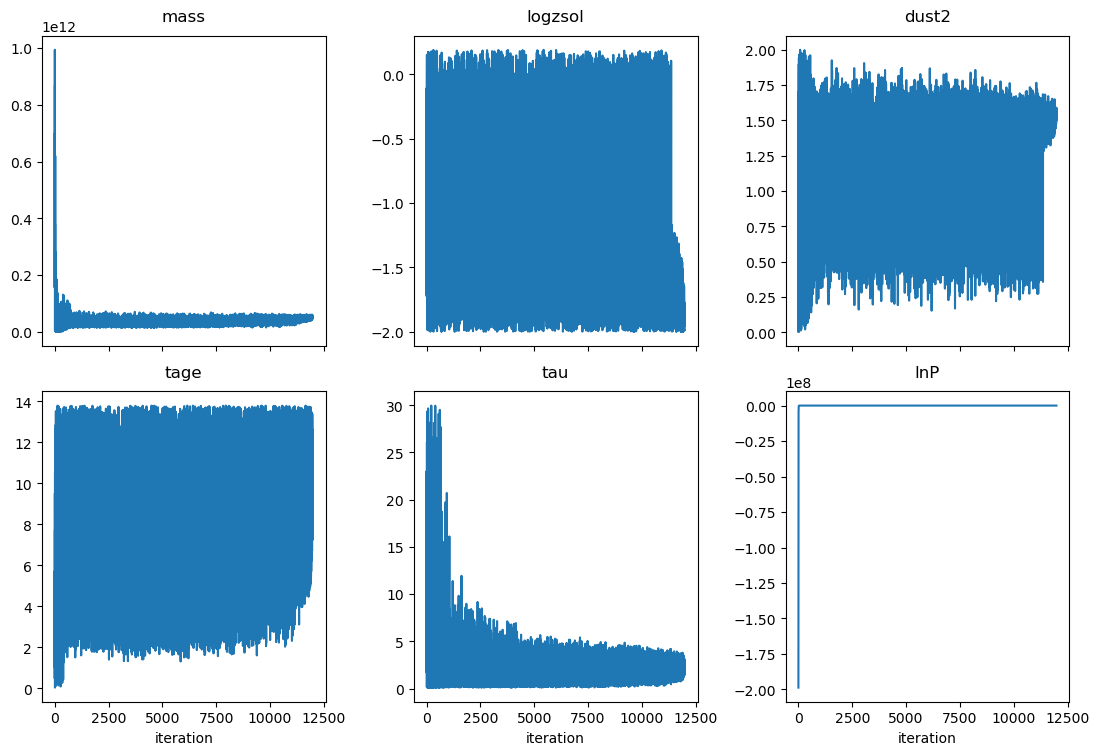

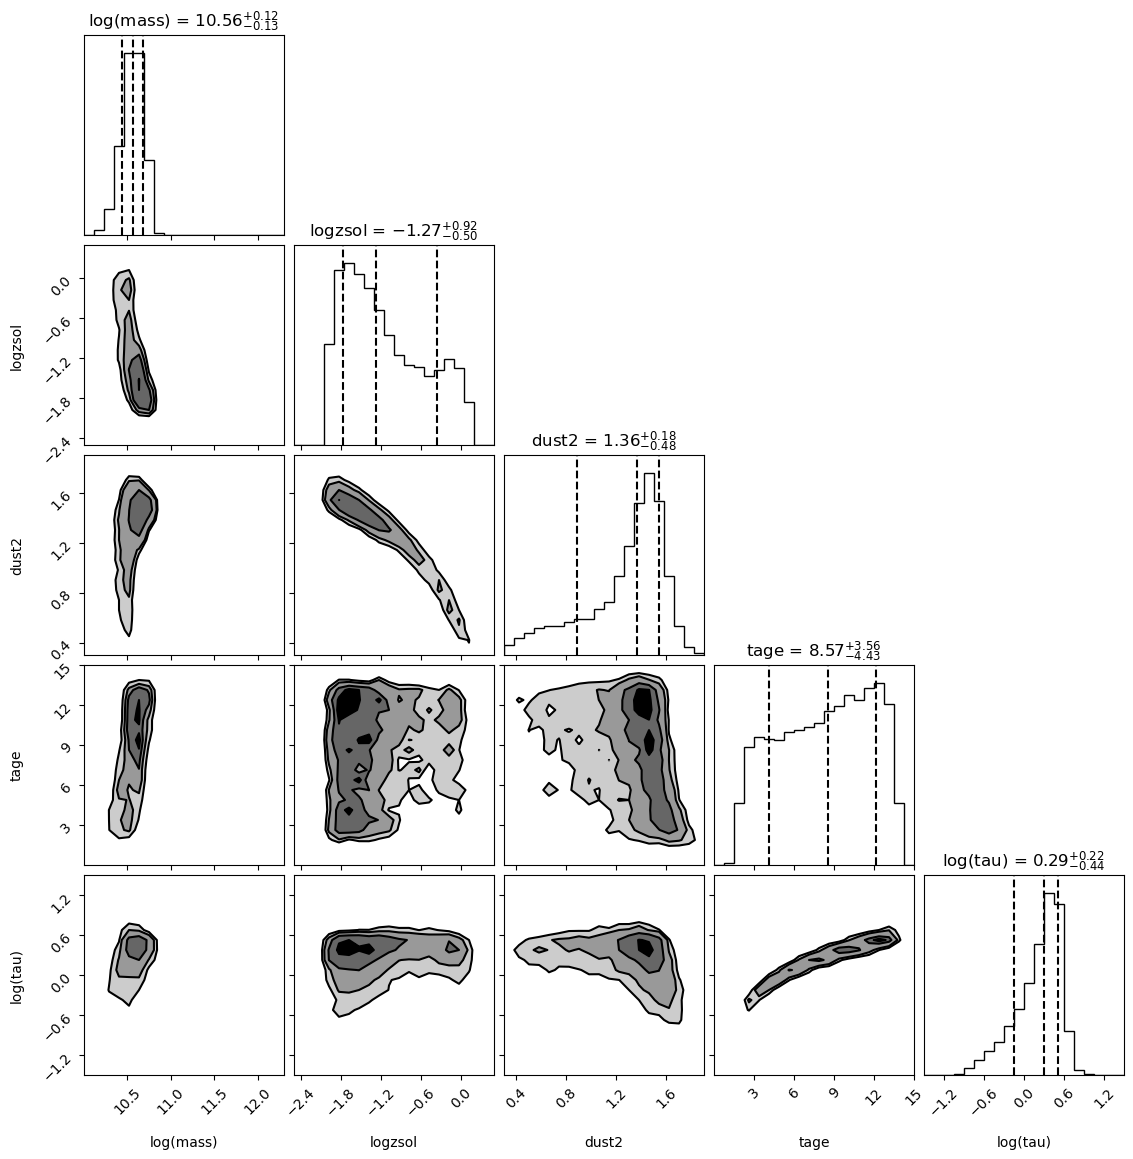

In [11]:
make_plots_for_h5(file2, ax_range=ax_range)

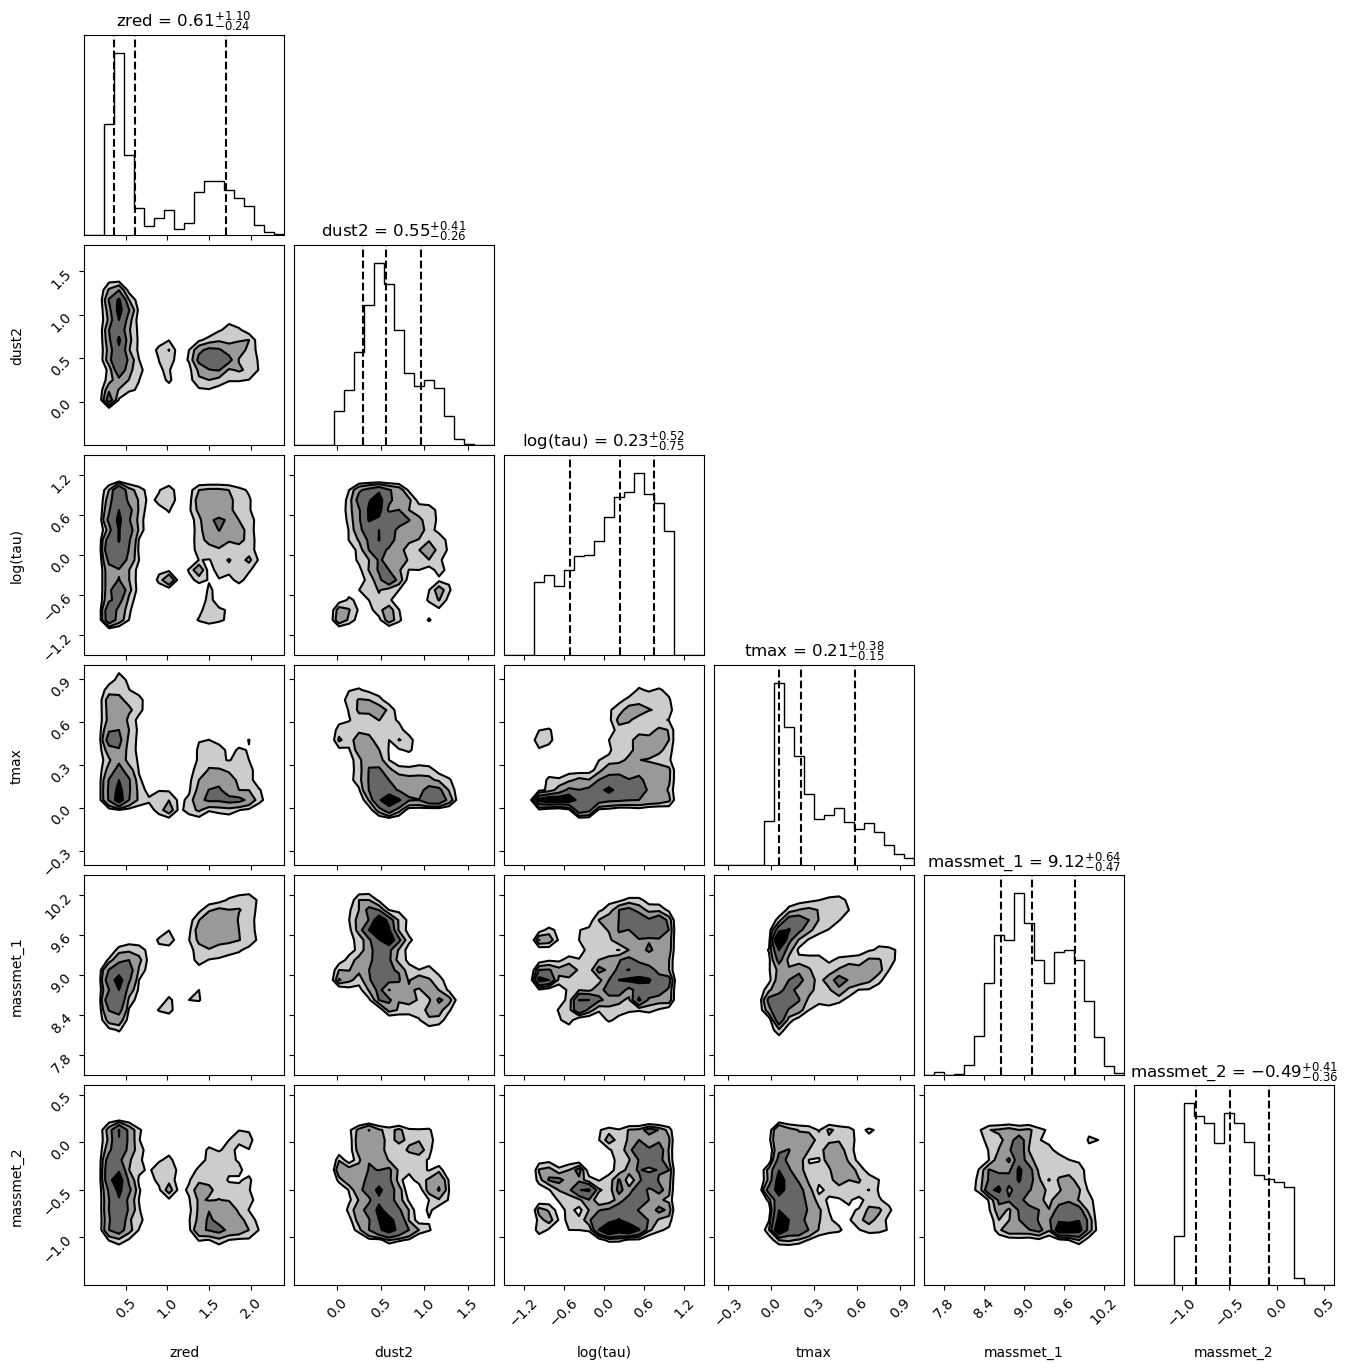

In [12]:
ax_range=[(0,2.4), (-.5, 1.8), (-1.5, 1.5), (-.4, 1), (7.5, 10.5), (-1.5, .6)]
make_plots_for_h5('160411A_1695844597_mcmc.h5', save=False, traceplot=False, ax_range=ax_range)

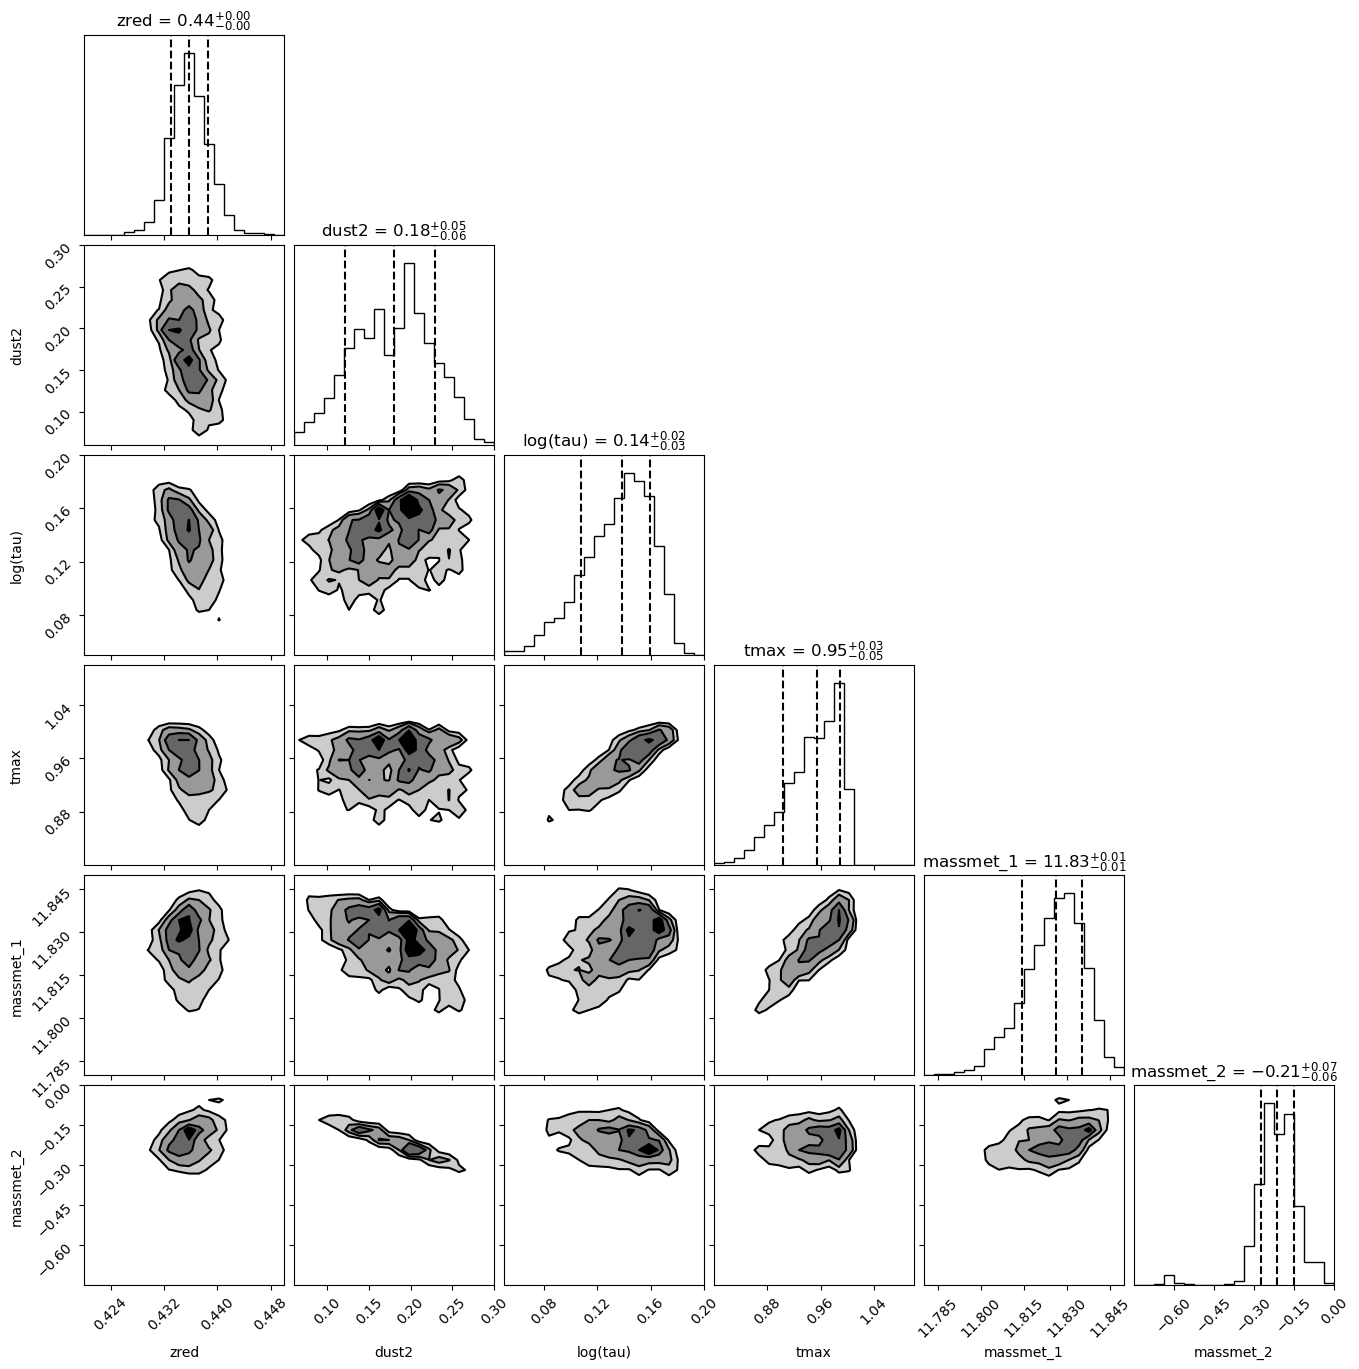

In [23]:
ax_range=[(.42,.45), (0.06, .3), (0.05, .2), (.8, 1.1), (11.78,11.85), (-.75, 0)]
make_plots_for_h5(file4, save=False, ax_range=ax_range)

# Examining block data

In [17]:
from astropy.table import Table
import os
os.environ['SPS_HOME'] = "/global/homes/e/eramey16/fsps"

In [18]:
t = Table.read('sweep-315m065-320m060-pz.fits')

RELEASE,BRICKID,OBJID,Z_PHOT_MEAN,Z_PHOT_MEDIAN,Z_PHOT_STD,Z_PHOT_L68,Z_PHOT_U68,Z_PHOT_L95,Z_PHOT_U95,Z_SPEC,SURVEY,TRAINING,KFOLD
int16,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,bytes12,bool,int16
